In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from lightgbm import LGBMClassifier



RANDOM_SEED = 42

## **DATA LOADING**

In [3]:
traindata = pd.read_csv( "train.csv" )
valdata = pd.read_csv( "val.csv" )
testdata  = pd.read_csv( "test.csv" )

In [4]:
#make summary DataFrame to check data

summary = pd.DataFrame({
    'unique_values': traindata.nunique(),
    'missing_values': traindata.isnull().sum(),
    'dtype': traindata.dtypes
})

# store original lengths of each dataset for splitting later
n_train = len(traindata)
n_val   = len(valdata)
n_test  = len(testdata)

df = pd.concat([traindata, valdata, testdata], axis=0, ignore_index=True)
print(df.head())


   p1  p2  p3  p4  p5  p6  p7  p8  p9  p10  ...  p36  p37  p38  p39  p40  p41  \
0   0   1  -1   1  -1   0   1   0   1   -1  ...    0    0    0    0    0    0   
1   0  -1  -1   1   0   0   0   0   1    0  ...    0    0    0    0    0    0   
2   0   1  -1   1   0   0   1   0   0   -1  ...    0    0    0    0    0    0   
3   1   0   0   0  -1   1   1  -1   0    0  ...    0    0    0    0    0    0   
4   1   1  -1  -1  -1   1  -1   1   0    0  ...   -1    0    0    0    0    0   

   p42  turn  label_move_col  id  
0    0     1             1.0 NaN  
1    0    -1             1.0 NaN  
2    0    -1             2.0 NaN  
3    0    -1             3.0 NaN  
4    1    -1             4.0 NaN  

[5 rows x 45 columns]


## **HELPER FUNCTIONS**

In [5]:
def check_horizontal_threats(board, heights, player):
    """
    counts 3-in-a-row horizontal threats then checks 
    if the winning move is on an odd or even row.
    """
    odd_threats = 0 # threats on row 1, 3, 5
    even_threats = 0 # threat on row 0, 2, 4
    
    # rows 0-5
    for r in range(6):
        
        # cols 0-3 (to check a window of 4)
        for c in range(4):
            window = board[r, c:c+4] # get the window
            
            # Check for [P, P, P, 0] or [P, P, 0, P] or [P, 0, P, P] or [0, P, P, P]
            if np.sum(window == player) == 3 and np.sum(window == 0) == 1:
                # if found 3-in-a-row with one empty spot
                # find the empty spot
                empty_col_local = np.where(window == 0)[0][0]
                empty_col_global = c + empty_col_local
                
                # check : IS IT PLAYABLE? (the spot bellow is filled)
                # height column must = row
                
                if heights[empty_col_global] == r:
                    
                    if r % 2 == 1: # odd -> row 1, 3, 5 (powerful)
                        odd_threats += 1
                    else: # even -> row 0, 2, 4 (weaker)
                        even_threats += 1
                        
    return odd_threats, even_threats

def check_vertical_threats(board, heights, player):
    """
    counts 3-in-a-row vertical threats
    """
    # vertical threat = [P, P, P, 0] (from bottom up)
    odd_threats = 0
    even_threats = 0
    
    # rows 0-2 (to check window of 4)
    for r in range(3):
        # cols 0-6
        for c in range(7):
            window = board[r:r+4, c] # Window from r to r+3
            
            # check for [P, P, P, 0]
            if window[0] == player and window[1] == player and window[2] == player and window[3] == 0:
                # The empty spot (r+3, c) is a playable threat

                winning_row = r + 3 
                if winning_row % 2 == 1: 
                    odd_threats += 1
                else: 
                    even_threats += 1
                    
    return odd_threats, even_threats

def check_diagonal_threats(board, heights, player):
    """
    counts 3-in-a-row diagonal threats (both directions)
    """
    odd_threats = 0
    even_threats = 0
    
    # 1. check (/) diagonals

    for r in range(3): # rows 0-2 (to check window of 4)
        for c in range(4): # cols 0-3 (to check window of 4)
            window = [board[r, c], board[r+1, c+1], board[r+2, c+2], board[r+3, c+3]]

            # check for 3 pieces and 1 empty spot
            if np.sum(np.array(window) == player) == 3 and np.sum(np.array(window) == 0) == 1:
                
                # found a threat so find the empty spot
                hole_idx = np.where(np.array(window) == 0)[0][0]
                hole_r = r + hole_idx
                hole_c = c + hole_idx
                
                # check if playable
                if heights[hole_c] == hole_r:
                    if hole_r % 2 == 1: 
                        odd_threats += 1
                    else: 
                        even_threats += 1
                    
    # 2. check (\) diagonals

    for r in range(3, 6): # rows 3-5 (start from top)
        for c in range(4): # cols 0-3 (to check window of 4)
            window = [board[r, c], board[r-1, c+1], board[r-2, c+2], board[r-3, c+3]]

            if np.sum(np.array(window) == player) == 3 and np.sum(np.array(window) == 0) == 1:
                
                # found a threat so find the empty spot
                hole_idx = np.where(np.array(window) == 0)[0][0]
                hole_r = r - hole_idx
                hole_c = c + hole_idx
                
                # check if playable
                if heights[hole_c] == hole_r:
                    if hole_r % 2 == 1: 
                        odd_threats += 1
                    else: 
                        even_threats += 1
                        
    return odd_threats, even_threats

In [6]:
def normalize_perspective(df):
    """
    flip the board so that '1' is always the current player
    """
    df = df.copy()
    feat_cols = [f"p{i}" for i in range(1, 43)] # columns

    boards = df[feat_cols].to_numpy().reshape(-1, 6, 7) # reshape to 6x7 boards

    # count pieces for each board
    count_1 = (boards == 1).sum(axis=(1,2))
    count_m1 = (boards == -1).sum(axis=(1,2))

    # if opponent turn
    mask = count_m1 > count_1  

    boards[mask] *= -1  # swap perspective

    # put back into dataframe and reshape
    df[feat_cols] = boards.reshape(-1, 42)

    return df

## **FEATURE ENGINEERING**

In [7]:
def create_features(df_original):
    """
    function that creates all the smart features
    """
    df = df_original.copy()

    feat_cols = [f"p{i}" for i in range(1, 43)]
    X = df[feat_cols].to_numpy()
    boards = X.reshape(-1, 6, 7) 
    heights = (boards != 0).sum(axis=1) # get column heights

    # --- Basic Features ---
    df["center_open"] = (heights[:, 3] < 6) # is center playable?
    
    for j in range(7):
        df[f"h{j+1}"] = heights[:, j] # height feauture for each column (h1, h2...h7)

    # current board state
    player_odd_threats_list = []
    player_even_threats_list = []
    opp_odd_threats_list = []
    opp_even_threats_list = []

    
    # go over each board
    for i in tqdm(range(len(boards)), desc="Creating Parity Features"):
        b = boards[i]             
        board_heights_original = heights[i] 
        
        # --- Calculate Parity ---
        # current state of odd/even threats for both players
        (p_odd_total, p_even_total) = (0, 0)
        (o_odd_total, o_even_total) = (0, 0)

        # check player 1 threats
        odd, even = check_horizontal_threats(b, board_heights_original, 1)
        p_odd_total += odd; p_even_total += even
        odd, even = check_vertical_threats(b, board_heights_original, 1)
        p_odd_total += odd; p_even_total += even
        odd, even = check_diagonal_threats(b, board_heights_original, 1)
        p_odd_total += odd; p_even_total += even

        # check opponent threats
        odd, even = check_horizontal_threats(b, board_heights_original, -1)
        o_odd_total += odd; o_even_total += even
        odd, even = check_vertical_threats(b, board_heights_original, -1)
        o_odd_total += odd; o_even_total += even
        odd, even = check_diagonal_threats(b, board_heights_original, -1)
        o_odd_total += odd; o_even_total += even
        
        # add the totals for this board to our lists
        player_odd_threats_list.append(p_odd_total)
        player_even_threats_list.append(p_even_total)
        opp_odd_threats_list.append(o_odd_total)
        opp_even_threats_list.append(o_even_total)

    # --- Add All New Features to the DataFrame ---
    
    df["player_odd_threats"] = player_odd_threats_list
    df["player_even_threats"] = player_even_threats_list
    df["opp_odd_threats"] = opp_odd_threats_list
    df["opp_even_threats"] = opp_even_threats_list
    # diff features, can be powerful
    df["odd_threat_diff"] = df["player_odd_threats"] - df["opp_odd_threats"]
    df["even_threat_diff"] = df["player_even_threats"] - df["opp_even_threats"]

    return df # final DataFrame with all 57 features

## **DATA PREPROCESSING**

In [8]:

# Normalize
train_norm = normalize_perspective(traindata)
val_norm   = normalize_perspective(valdata)
test_norm  = normalize_perspective(testdata)


# Create features for all 3 datasets

train_final = create_features(train_norm) 
valid_final = create_features(val_norm) 
test_final  = create_features(test_norm)

# Convert boolean features to int
for df in [train_final, valid_final, test_final]:
    for col in df.select_dtypes('bool').columns:
        df[col] = df[col].astype(int)

# Get X and y
X_train = train_final.drop("label_move_col", axis=1)
y_train = train_final["label_move_col"]

X_valid = valid_final.drop("label_move_col", axis=1)
y_valid = valid_final["label_move_col"]



Creating Parity Features: 100%|██████████| 10868/10868 [00:05<00:00, 2034.08it/s]


## **Ensemble MODEL TRAINING (XGB + LGBM + RF)**

In [9]:
print("Training the Ensemble model....")

# --- Model 1: XGBoost ---
# we use the best params we found

clf1 = XGBClassifier(
    objective="multi:softmax",
    num_class=7,
    random_state=42,
    learning_rate=0.2,
    max_depth=9,
    n_estimators=400,
    n_jobs=-1
)

# --- Model 2: LightGBM  ---
# similar powerful parameters

clf2 = LGBMClassifier(
    objective="multiclass",
    num_class=7,
    random_state=42,
    learning_rate=0.2,
    max_depth=9,
    n_estimators=400,
    n_jobs=-1
)

# --- Model 3: Random Forest  ---
# think differently than boosting models (like XGB/LGBM), gives diversity

clf3 = RandomForestClassifier(
    n_estimators=400,  # RFs need a lot of trees
    max_depth=15,      # RFs can be deeper
    random_state=42,
    n_jobs=-1
)

# --- The Ensemble: VotingClassifier ---
# combine all three using 'soft' voting
# add weight and we give XGBoost (clf1) the most since we trust it the most

eclf = VotingClassifier(
    estimators=[
        ('xgb', clf1), 
        ('lgbm', clf2),
        ('rf', clf3)
    ],
    voting='soft',  
    weights=[0.5, 0.3, 0.2]  # XGB 50% 
)


eclf.fit(X_train, y_train)

xgb = eclf

print("Ensemble training complete.")

Training the Ensemble model....
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 49993, number of used features: 57
[LightGBM] [Info] Start training from score -1.946731
[LightGBM] [Info] Start training from score -2.498217
[LightGBM] [Info] Start training from score -2.317965
[LightGBM] [Info] Start training from score -1.040977
[LightGBM] [Info] Start training from score -2.317965
[LightGBM] [Info] Start training from score -2.498217
[LightGBM] [Info] Start training from score -1.946731
Ensemble training complete.


In [10]:
weights_filename = 'weights.joblib' 
joblib.dump(xgb, weights_filename)

print(f"\nSuccessfully saved the ensemble model to {weights_filename}")


Successfully saved the ensemble model to weights.joblib


## **EVALUATION**

In [11]:
# predict on original validation set
print("Evaluating model...")

val_pred = xgb.predict(valid_final.drop("label_move_col", axis=1))

print(accuracy_score (y_valid, val_pred) )

Evaluating model...
0.6856320772229442


In [12]:
# --- Feature Importance ---
print("--- Feature Importances for the ENSEMBLE ---")

# we ask our main 'xgb' model inside the ensemble
xgb_inner_model = xgb.named_estimators_['xgb']

feat_names = X_train.columns

importances = xgb_inner_model.feature_importances_

imp_series = pd.Series(importances, index=feat_names)

# Sort the series from highest to lowest
imp_sorted = imp_series.sort_values(ascending=False)

print("\n--- Sorted Importances (from the XGBoost model) ---")
print(imp_sorted)


--- Feature Importances for the ENSEMBLE ---

--- Sorted Importances (from the XGBoost model) ---
player_even_threats    0.071682
opp_even_threats       0.060274
player_odd_threats     0.044650
h4                     0.044189
opp_odd_threats        0.035563
center_open            0.031197
even_threat_diff       0.026902
odd_threat_diff        0.019854
p24                    0.016361
p26                    0.016182
p22                    0.015822
h3                     0.015357
p27                    0.015327
p33                    0.015232
h5                     0.015225
p28                    0.015214
p31                    0.015070
p34                    0.014817
h1                     0.014651
h7                     0.014635
p17                    0.014491
p23                    0.014482
p30                    0.014389
p20                    0.014334
p32                    0.014316
p5                     0.014286
p4                     0.014210
p3                     0.014051
p16   

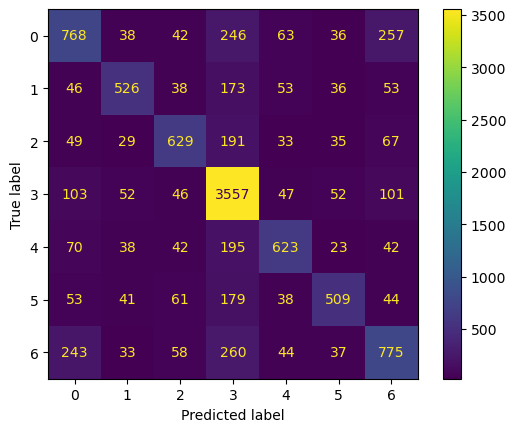

0.6856320772229442


In [13]:
# --- Confusion Matrix ---

xgb_CM = confusion_matrix(y_valid, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_CM, display_labels= xgb.classes_)
disp.plot()
plt.show()

print(accuracy_score(y_valid,val_pred))

## **Save the test predictions to CSV file to submitted to kaggle**

In [14]:
print("Creating submission file...")

X_test_final = test_final[X_train.columns]

test_predictions = xgb.predict(X_test_final)

# new DataFrame for the submission
submit = pd.DataFrame({
    'id': testdata['id'],  # 'id' column from the original test data
    'label_move_col': test_predictions # use our model's predictions
})

# turn columns to integers to match the submission format
submit['id'] = submit['id'].astype(int)
submit['label_move_col'] = submit['label_move_col'].astype(int)

# save DataFrame to a CSV file
submit.to_csv('Submission_Ensemble_Final.csv', index=False)

print("Submission file created: 'Submission_Ensemble_Final.csv'")
print(submit.head())

Creating submission file...
Submission file created: 'Submission_Ensemble_Final.csv'
   id  label_move_col
0   1               6
1   2               2
2   3               4
3   4               6
4   5               3
